<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/nyu-deep-learning-2020/03_spiral_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Spiral classification

**Reference**:

[Artificial neural networks (ANNs)](https://atcold.github.io/pytorch-Deep-Learning/en/week02/02-3/)

In [ ]:
!git clone https://github.com/Atcold/pytorch-Deep-Learning
!cp -r pytorch-Deep-Learning/res .
!rm -rf pytorch-Deep-Learning

In [5]:
# Load libraries
import torch
import torch.nn as nn
from torch import nn, optim

import random
import math

from IPython import display
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib.pyplot import plot, title, axis

In [3]:
# Set style (needs to be in a new cell)
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Training data

The following are data used as training input for a network.

* $X$ represents the input data, a matrix of dimensions $m$ (number of training data points) x $n$ (dimensionality of each input point).

* Vector ${c}$ and matrix $\boldsymbol{Y}$ both represent class labels for each of the mm data points.


In [6]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

N = 1000  # num_samples_per_class
D = 2     # dimensions
C = 3     # num_classes
H = 100   # num_hidden_units

Like before, we are going to be working with points in ${R}^2$
  with three different categorical labels – in red, yellow and blue.

In [7]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
  index = 0

  # When c = 0 and t = 0: start of linspace
  # When c = 0 and t = 1: end of linpace
  T = torch.linspace(0, 1, N)

  # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
  inner_var = torch.linspace(
    (2 * math.pi / C) * (c),      # When t = 0
    (2 * math.pi / C) * (2 + c),  # When t = 1
    N
  ) + torch.randn(N) * 0.2

  for ix in range(N * c, N * (c + 1)):
    X[ix] = T[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
    y[ix] = c
    index += 1

print("Shapes:")
print(f"X: {tuple(X.size())}")
print(f"y: {tuple(y.size())}")

Shapes:
X: (3000, 2)
y: (3000,)


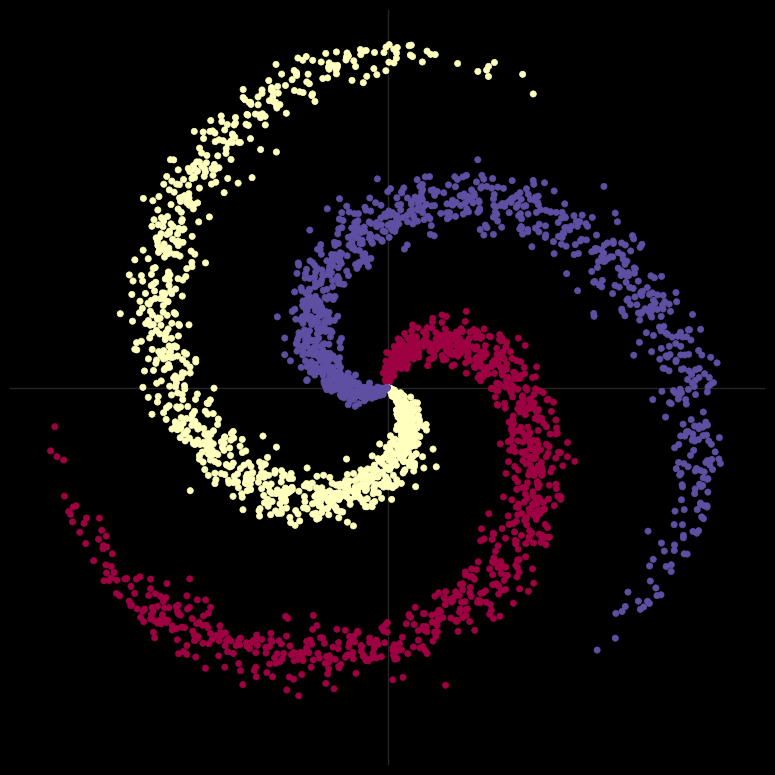

In [8]:
# visualise the data
plot_data(X, y)

## Linear decision boundaries(Linear Transformations)

A linear transformation can be represented as a matrix. Using singular value decomposition, we can decompose this matrix into three component matrices, each representing a different linear transformation.

Let's generate a random matrix $W$

$
\begin{equation}
    W = U
  \left[ {\begin{array}{cc}
   s_1 & 0 \\
   0 & s_2 \\
  \end{array} } \right]
  V^\top
\end{equation}
$
* Compute $y = Wx$
* Larger singular values stretch the points
* Smaller singular values push them together
* $U, V$ rotate/reflect

Let's do it with **Numpy**.

In [ ]:
show_scatterplot(X, colors, title="X")
plot_bases(OI)

for i in range(10):
  # create a random matrix
  W = torch.randn(2, 2).to(device)
  # transform points
  Y = X @ W.t()
  # compute singular values
  U, S, V = torch.svd(W)
  # plot transformed points
  show_scatterplot(Y, colors, title=f"y = Wx, singular values : [{S[0]:.3f}, {S[1]:.3f}]")
  # transform the basis
  new_OI = OI @ W.t()
  # plot old and new basis
  plot_bases(OI)
  #plot_bases(new_OI)

We can visualize the linear transformations of several random matrices. Note the effect of the singular values on the resulting transformations.

Now, let's do it with **PyTorch**.

In [ ]:
model = nn.Sequential(nn.Linear(2, 2, bias=False))
model.to(device)

with torch.no_grad():
  Y = model(X)
  show_scatterplot(Y, colors)
  plot_bases(model(OI))

##Non-linear transformations

* Linear transforms can rotate, reflect, stretch and compress, but cannot curve
* We need non-linearities for this
* Can (approximately) map points to a square by first stretching out by a factor $s$, then squashing with a tanh function

$
   f(x)= \tanh \left(
  \left[ {\begin{array}{cc}
   s & 0 \\
   0 & s \\
  \end{array} } \right]  
  x
  \right)
$

In [ ]:
z = torch.linspace(-10, 10, 101)
s = torch.tanh(z)

plot(z.numpy(), s.numpy())
title("tanh() non linearity");

By forcing more points to the edge, we spread them out more and can then attempt to classify them.

In [ ]:
show_scatterplot(X, colors, title="X")
plot_bases(OI)

model = nn.Sequential(
  nn.Linear(2, 2, bias=False),
  nn.Tanh()
)
model.to(device)

for s in range(1, 6):
  W = s * torch.eye(2)
  model[0].weight.data.copy_(W)
  Y = model(X).data
  show_scatterplot(Y, colors, title=f"(x), s={s}")
  plot_bases(OI, width=0.01)

##Neural Networks Transformation 

Lastly, we visualize the transformation performed by a simple, untrained neural network.

Going forward, we will see how to make these transformations performed by neural networks useful for our end goal of classification.

In [ ]:
show_scatterplot(X, colors, title="x")
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()

for i in range(5):
  # create 1-layer neural networks with random weights
  model = nn.Sequential(
    nn.Linear(2, n_hidden),
    NL,
    nn.Linear(n_hidden, 2)
  )
  model.to(device)

  with torch.no_grad():
    Y = model(X)
  show_scatterplot(Y, colors, title="f(x)")
  #plot_bases(OI)

In [ ]:
show_scatterplot(X, colors, title="x")
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()

for i in range(5):
  # create 4-layer neural networks with random weights
  model = nn.Sequential(
    nn.Linear(2, n_hidden),
    NL,
    nn.Linear(n_hidden, n_hidden),
    NL,
    nn.Linear(n_hidden, n_hidden),
    NL,
    nn.Linear(n_hidden, n_hidden),
    NL,
    nn.Linear(n_hidden, 2),
  )
  model.to(device)

  with torch.no_grad():
    Y = model(X).detach()
  show_scatterplot(Y, colors, title="f(x)")